This validation case reproduces H absorption curves for Ti at different temperatures obtained by [Y. Hirooka et al.](https://www.sciencedirect.com/science/article/abs/pii/0022311581905663). 

Absorption experiments were performed in the vacuum chamber at the base pressure of $1.3\times10^4$ Pa with $10\times13\times1\,\mathrm{mm}^{3}$ cold rolled Ti strips. Absorption curves were acquired at the fixed sample temperature ranging from $450\degree\mathrm{C}$ to $650\degree\mathrm{C}$. 

The FESTIM model is based on the work of [Y. Shimohata et al.](https://www.sciencedirect.com/science/article/pii/S0920379621006098?via%3Dihub). By following the approach, evolution of the surface H concentration is assumed to be driven by adsorption from the gas phase and recombination. Only a half of the sample is simulated for simplicity.

The H diffusivity in Ti is taken from the report of [G. Wille and J.W. Davis](https://www.osti.gov/servlets/purl/6420120).

The FESTIM results are compared to the experimental data of [Y. Shimohata et al.](https://www.sciencedirect.com/science/article/pii/S0920379621006098?via%3Dihub), extracted with [PlotDigitizer](https://plotdigitizer.com/).

# FESTIM model

In [8]:
import festim as F
import fenics as f
import numpy as np
import h_transport_materials as htm
import matplotlib.pyplot as plt

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19  # elementary charge, C
M_H2 = 2.016e-3 / N_A_const  # the H2 mass, kg mol^-1

# Sample size
A = 1e-2 * 1.3e-2  # Ti surface area (1cm x 1.3cm), m^2
L = 1e-3 / 2  # Ti thickness, m
V = A * L  # Ti volume (1cm x 1.3cm x 1mm), m^-3

# Ti properties
X_max = 3  # maximum number of H atoms per a Ti atom in the bulk
n_b = 9.4e4 * N_A_const  #  the number of atomic sites per unit of volume of Ti, m^-3
n_surf = (
    X_max * 2.16e-5 * N_A_const
)  # the number of atomic sites per unit of surface area of Ti, m^-2
N_Ti = n_b * V  #  the number of moles of Ti
n_IS = X_max * n_b
lambda_Ti = n_surf / n_IS

# Properties of fluxes
D = htm.diffusivities.filter(material=htm.TITANIUM, author="wille")[0]
D0 = D.pre_exp.magnitude  # diffusivity pre-factor, m^2 s^-1
E_diff = D.act_energy.magnitude  # diffusion activation energy, eV

E_des = F.kJmol_to_eV(1.17e5 / 1e3)  # activateion energy for desorption, eV
k_des = 1.08e8 * N_A_const / n_surf**2  # desorption rate, m^2 s^-1

E_sb = F.kJmol_to_eV(
    1.18e2
)  # the activation energy value for the inward subsurface transport, eV
k_sb = 1.16e11  # frequency factor for the inward subsurface transport, s^-1

E_bs = F.kJmol_to_eV(
    8.5e1
)  # the activation energy value for the outward subsurface transport, eV
k_bs = 3.24e9  # frequency factor for the outward subsurface transport, s^-1

# Chamber
V_ch = 2.95e-3  # the chamber volume, m^3
P0 = 1.3e4  # the initial pressure, Pa


################### FUNCTIONS ###################
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)


def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) + (X0 - X) / 2)


def J_vs(T, surf_conc, X):
    J_ads = (
        2
        * S0(T)
        * (1 - surf_conc / n_surf) ** 2
        * P_H2(T, X)
        / (2 * np.pi * M_H2 * F.k_B * T * e) ** 0.5
    )
    J_des = 2 * k_des * surf_conc**2 * f.exp(-E_des / F.k_B / T)
    return J_ads - J_des


def K_sb(T, surf_conc, X):
    return k_sb * f.exp(-E_sb / F.k_B / T)


def K_bs(T, surf_conc, X):
    return k_bs * f.exp(-E_bs / F.k_B / T)


################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()

        # Compute Content
        surf = f.assemble(
            self.h_transport_problem.boundary_conditions[0].solutions[0]
            * self.mesh.ds(1)
        )
        X = 2 * (f.assemble(self.mobile.solution * self.mesh.dx) + surf) * A

        # Normalised content parameter
        self.h_transport_problem.boundary_conditions[0].prms["X"].assign(X)

We can now define a function that will run a FESTIM model for different cases:

In [9]:
def run_sim(T0):
    Ti_model_impl = CustomSimulation()

    # Mesh
    vertices = np.linspace(0, L, num=1000)

    Ti_model_impl.mesh = F.MeshFromVertices(vertices)

    # Materials
    Ti_model_impl.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    surf_conc = F.SurfaceKinetics(
        k_bs=K_bs,
        k_sb=K_sb,
        lambda_IS=lambda_Ti,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        X=0,
    )

    # Boundary conditions
    Ti_model_impl.boundary_conditions = [surf_conc]

    # Homogenous temperature
    Ti_model_impl.T = F.Temperature(value=T0)

    # Exports
    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalVolume(field="solute", volume=1)],
        show_units=True,
    )

    Ti_model_impl.exports = [derived_quantities]

    Ti_model_impl.dt = F.Stepsize(
        initial_value=1e-3, stepsize_change_ratio=1.1, max_stepsize=5, dt_min=1e-5
    )

    Ti_model_impl.settings = F.Settings(
        absolute_tolerance=1e6,
        relative_tolerance=1e-4,
        maximum_iterations=50,
        final_time=25 * 60,
    )

    Ti_model_impl.initialise()
    Ti_model_impl.run()

    return derived_quantities

We now run the FESTIM model for the five cases with different material temperatures:

In [10]:
T_list = [
    450 + 273,
    500 + 273,
    550 + 273,
    600 + 273,
    650 + 273,
]  # reference data is given in deg C

results = {}
for T0 in T_list:
    results[T0] = run_sim(T0)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        1.5e+03 s    Elapsed time so far: 8.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so

# Comparison with experimental data

FESTIM reasonably reproduces the experimental data using one set of parameters.

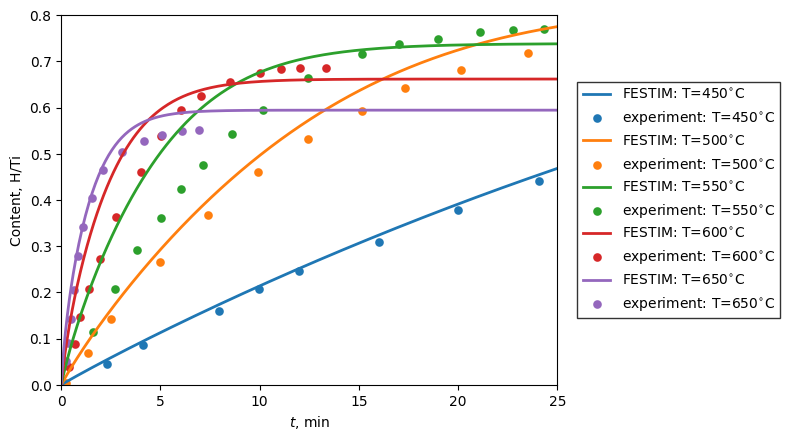

In [11]:
def plot_inventory(T0, FESTIM_data):
    retention = np.array(FESTIM_data[1].data) + np.array(
        FESTIM_data[0].data
    )  # half of the sample
    t = np.array(FESTIM_data.t)

    plt.plot(
        t / 60,
        retention * A / N_Ti,
        lw=2,
        label=f"FESTIM: T={T0-273}" + r"$^{\circ}$C",
        ls="solid",
    )

    exp = np.loadtxt(f"./reference_data/{T0-273}.csv", delimiter=",", skiprows=1)
    plt.scatter(
        exp[:, 0],
        exp[:, 1],
        s=25,
        linewidths=1.2,
        label=f"experiment: T={T0-273}" + r"$^{\circ}$C",
    )


for T0 in T_list:
    plot_inventory(T0, results[T0])

plt.ylabel("Content, H/Ti")
plt.xlabel("$t$, min")
plt.ylim(0, 0.8)
plt.xlim(0, 25)
plt.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc="center left",
    borderaxespad=0,
    fancybox=False,
    edgecolor="black",
)
plt.show()

# Paper-quality figure

/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/pypalettes/utils.py:5: DeprecationWarning: open_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_binary('pypalettes', path) as f:


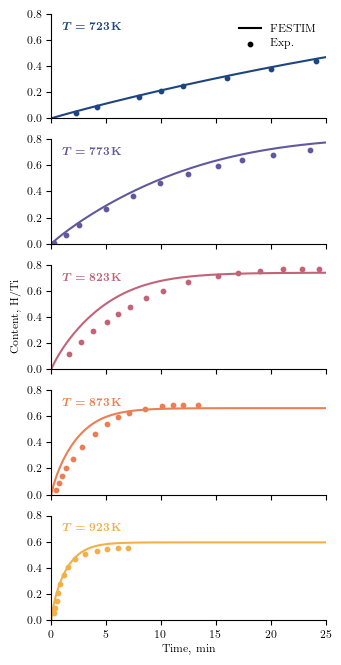

In [12]:
from pypalettes import load_cmap

cmap = load_cmap("Sunset2")

params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{bm}",
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
        ]
    ),
    "font.size": 8,
    "font.family": "Times New Roman",
    "axes.spines.right": False,
    "axes.spines.top": False,
}
plt.rcParams.update(params)


def plot_inventory(axis, T0, FESTIM_data, color):
    retention = np.array(FESTIM_data[1].data) + 2 * np.array(FESTIM_data[0].data)
    t = np.array(FESTIM_data.t)

    axis.plot(
        t / 60, retention * A / N_Ti, lw=1.5, label=f"FESTIM", ls="solid", color=color
    )

    exp = np.loadtxt(f"./reference_data/{T0-273}.csv", delimiter=",", skiprows=1)
    axis.scatter(exp[:, 0], exp[:, 1], s=10, label=f"Exp.", color=color)


mm2inch = 0.1 / 2.54
fig, axs = plt.subplots(
    5, 1, figsize=(90 * mm2inch, 200 * mm2inch), sharex=True, sharey=True
)

for i, (axis, T0) in enumerate(zip(axs, T_list)):
    plot_inventory(axs[i], T0, results[T0], cmap(i))

    axis.text(
        1,
        0.7,
        rf"$\bm{{T={T0}}}\,\textbf{{\si{{K}}}}$",
        ha="left",
        va="center",
        color=cmap(i),
    )

(dummy_line,) = axs[0].plot([-1], [-1], color="black", lw=1.5, label="FESTIM")
dummy_dot = axs[0].scatter([-1], [-1], color="black", s=10, label="Exp.")


axs[0].legend(handles=[dummy_line, dummy_dot], loc="best", frameon=False)
axs[2].set_ylabel("Content, H/Ti")
axs[-1].set_xlabel(r"Time, \si{min}")
axs[-1].set_ylim(0, 0.8)
axs[-1].set_xlim(0, 25)

# plt.savefig("./H_Ti.pdf", dpi=1000, bbox_inches="tight", pad_inches=0.01)
plt.show()